In [1]:
import numpy as np
from PIL import Image
import os
from utils import read_image

In [2]:
def reflect_image(image, offset):
    x, y = image.shape
    ans = np.zeros((x+2*offset, y+2*offset))
    ans[offset:x+offset, offset: y+offset] = image
    
    top = image[0]
    bottom = image[-1]
    left = image[:, 0]
    right = image[:, -1]
    for i in range(offset):
        ans[i, offset:y+offset] = top
        ans[i+x+offset, offset:y+offset] = bottom
        ans[offset:x+offset, i] = left
        ans[offset:x+offset, i+y+offset] = right
    first = image[0, 0]
    second = image[0, -1]
    third = image[-1, 0]
    fourth = image[-1, -1]
    for i in range(offset):
        for j in range(offset):
            ans[i, j] = first
            ans[i, j+y+offset] = second
            ans[i+x+offset, j] = third
            ans[i+x+offset, j+y+offset] = fourth
    
    return ans

def mask(shape):
    #Pattern is RGGB
    red, green, blue = np.zeros(shape), np.zeros(shape), np.zeros(shape)
    red[1::2, 1::2] = 1
    green[0::2, 1::2] = 1
    green[1::2, 0::2] = 1
    blue[0::2, 0::2] = 1
    return red, green, blue

In [3]:
left_right = [(0, -1), (0, 1)]
up_down = [(1, 0), (-1, 0)]
near_neighbors = left_right + up_down

left_right_2_offset = [(0, -2), (0, 2)]
up_down_2_offset = [(2, 0), (-2, 0)]
near_same_r_b = left_right_2_offset + up_down_2_offset

diag_anti_diag = [(-1, -1), (1, 1), (-1, 1), (1, -1)]
left_right_diag = diag_anti_diag + left_right_2_offset
up_down_diag = diag_anti_diag + up_down_2_offset

divisor = 8
alpha = 1
beta = 1
gamma = 1

In [4]:
def get_addition(offset_array, image, x, y, weight=1.0):
    total = 0
    for x1, y1 in offset_array:
        total += weight*image[x+x1][y+y1]
    return total
    
def fill_g_br(image, x, y):
    curr = get_addition(near_neighbors, image, x, y, 2.0)
    grad = get_addition(near_same_r_b, image, x, y, -1.0)
    already = 4*image[x][y]
    return (curr + alpha*(already + grad))/(divisor)

def fill_br_br(image, x, y):
    curr = get_addition(diag_anti_diag, image, x, y, 2.0)
    grad = get_addition(near_same_r_b, image, x, y, -1.5)
    already = 6*image[x][y]
    return (curr + gamma*(already + grad))/(divisor)

def fill_br_g(image, x, y, up):
    curr = get_addition(up_down if up else left_right, image, x, y, 4.0)
    grad = get_addition(up_down_diag if up else left_right_diag, image, x, y, -1.0)
    already = get_addition(left_right_2_offset if up else up_down_2_offset, image, x, y, 0.5)
    already += 5*image[x][y]
    return (curr + beta*(already + grad))/(divisor)

In [5]:
def bayer_to_rgb(file):
    offset = 2
    img = read_image(file)
    image = reflect_image(img, offset)
    shape = img.shape
    
    rm, gm, bm = mask(shape)
    R, G, B = rm*img, gm*img, bm*img
    
    for i in range(shape[0]):
        if(i%100==0):
            print(i)
        for j in range(shape[1]):
            assert(rm[i][j]+gm[i][j]+bm[i][j] == 1)
            if not gm[i][j]:
                G[i][j] = fill_g_br(image, i+offset, j+offset)
                temp = fill_br_br(image, i+offset, j+offset)
                if not rm[i][j]:
                    R[i][j] = temp
                else:
                    B[i][j] = temp
            else:
                R[i][j] = fill_br_g(image, i+offset, j+offset, up = (i%2==0)) 
                B[i][j] = fill_br_g(image, i+offset, j+offset, up = (i%2==1))
                
    return np.rint(R).astype('uint8'), np.rint(G).astype('uint8'), np.rint(B).astype('uint8')

In [6]:
def mse(Original, New, total):
    return np.sum(np.power(Original-New, 2))/total

def psnr(Original, New, total):
    m = mse(Original, New, total)
    return 10*np.log10((255*255)/m)

In [7]:
def process_bayer(folder):
    
    file = os.path.join(folder, 'bayer.jpg')
    original = os.path.join(folder, 'color.png')
    
    R, G, B = bayer_to_rgb(file)
    image = Image.fromarray(np.dstack([R, G, B]))
    path = os.path.join(folder, 'transformed.png')
    image.save(path)
    
    original_image = read_image(original)
    RO, GO, BO = original_image[:, :, 0], original_image[:, :, 1], original_image[:, :, 2]
    shape = original_image.shape
    total = shape[0]*shape[1]
    
    print("Red PSNR", psnr(RO, R, total))
    print("Green PSNR", psnr(GO, G, total))
    print("Blue PSNR", psnr(BO, B, total))
    
    return image

0
100
200
300
400
500
600
700
Red PSNR 35.2829215605601
Green PSNR 37.81580158407741
Blue PSNR 35.09955445803874


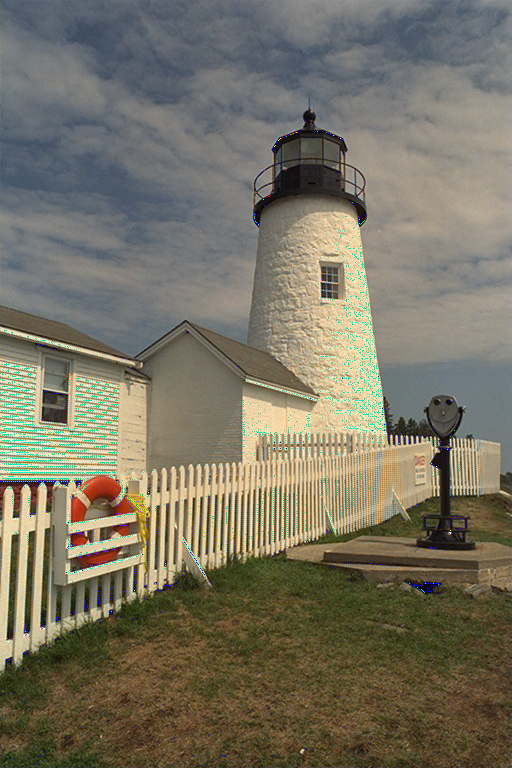

In [8]:
folder = './data/demosaicing/4'
process_bayer(folder)